# Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, utils
from tensorflow import keras
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '../../')
from plot_graphs import plot_loss, plot_acc

# Setting Image and Batch Size

In [2]:
IMAGE_SIZE = 100
BATCH_SIZE = 32

# Loading the train, val, and test data

In [3]:
train = utils.image_dataset_from_directory("../../datasets/data/split/Zenodo/train", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
val = utils.image_dataset_from_directory("../../datasets/data/split/Zenodo/val", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
test = utils.image_dataset_from_directory("../../datasets/data/split/Zenodo/test", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 3360 files belonging to 6 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 720 files belonging to 6 classes.
Found 720 files belonging to 6 classes.


2022-08-07 14:57:02.961530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-07 14:57:02.961632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Adding augmentation layer

In [4]:
# Using this method for M1 Mac CPU acces to run augmentation
with tf.device('/cpu:0'):
  data_augmentation = keras.Sequential(
  [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
      layers.RandomContrast(0.2),
      # layers.RandomTranslation(height_factor=0.2,width_factor=0.3)
  ] 
  )

# Defining the model

In [5]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
with tf.device('/cpu:0'):
  x = data_augmentation(x)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                             

# Adding Callbacks

In [6]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="../../models/zenodo/m4_Augmentation.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

# Running the model

In [7]:
history = model.fit(
  train.cache(),
  epochs=40,
  callbacks=callbacks_list,
  validation_data=val.cache()
)

Epoch 1/40


2022-08-07 14:57:03.897787: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-07 14:57:03.897912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 1.7802 - accuracy: 0.1997

2022-08-07 14:57:11.144551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 8s 64ms/step - loss: 1.7802 - accuracy: 0.1997 - val_loss: 2.0597 - val_accuracy: 0.1750
Epoch 2/40
105/105 [==============================] - 6s 59ms/step - loss: 1.7026 - accuracy: 0.2884 - val_loss: 3.4609 - val_accuracy: 0.1903
Epoch 3/40
105/105 [==============================] - 6s 61ms/step - loss: 1.6060 - accuracy: 0.3631 - val_loss: 2.7750 - val_accuracy: 0.1917
Epoch 4/40
105/105 [==============================] - 6s 59ms/step - loss: 1.4985 - accuracy: 0.4167 - val_loss: 1.8351 - val_accuracy: 0.3319
Epoch 5/40
105/105 [==============================] - 6s 59ms/step - loss: 1.3765 - accuracy: 0.4577 - val_loss: 1.7125 - val_accuracy: 0.3403
Epoch 6/40
105/105 [==============================] - 7s 65ms/step - loss: 1.2982 - accuracy: 0.4908 - val_loss: 1.5191 - val_accuracy: 0.3861
Epoch 7/40
105/105 [==============================] - 7s 62ms/step - loss: 1.2328 - accuracy: 0.5226 - val_loss: 1.2138 - val_accuracy: 0.4583
Epoch 8/40

# Evaluating the model

In [8]:

# model.evaluate(test)

load_model = keras.models.load_model("../../models/zenodo/m4_Augmentation.h5")
load_model.evaluate(test)

 3/23 [==>...........................] - ETA: 0s - loss: 0.2176 - accuracy: 0.9167

2022-08-07 15:01:12.851452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 19ms/step - loss: 0.4118 - accuracy: 0.8569


[0.41178131103515625, 0.8569444417953491]

# Plotting loss and accuracy graphs

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/pyplot.py'>

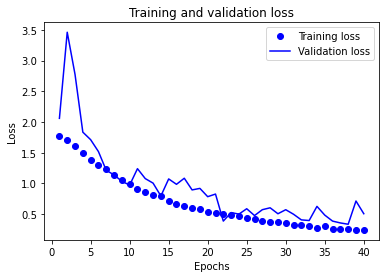

In [9]:
# Plotting loss and accuracy graphs
## Plotting loss
plot_loss(history)

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/pyplot.py'>

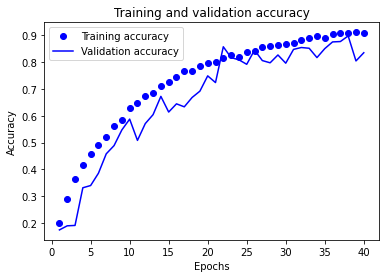

In [10]:
## Plotting accuracy
plot_acc(history)